In [1]:
import numpy as np
import pandas as pd
import torch
import csv
import json
import transformers
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F

from transformers import AutoTokenizer, BertForSequenceClassification, BertConfig, BertModel

device = 'cuda'

In [2]:
df1 = pd.read_csv('bert_linear/test_result_db2.csv')
df2 = pd.read_csv('hfl_bert_linear/test_result_db2.csv')
df3 = pd.read_csv('bert_gru/test_result_db2.csv')
df4 = pd.read_csv('bert_lstm/test_result_db2.csv')
df5 = pd.read_csv('RoBERTa_linear/test_result_db2.csv')


In [3]:
df3[df3.id != df3.label].sample(20)

,id,label,text
557,2,1,"['[CLS]', '你', '大', '爷', '是', '不', '是', '觉', '..."
13863,1,2,"['[CLS]', '期', '待', '您', '的', '回', '复', '担', '..."
12896,0,2,"['[CLS]', '有', '个', '黑', '[SEP]', '[PAD]', '[P..."
4571,0,2,"['[CLS]', '那', '我', '已', '经', '超', '出', '500',..."
5076,0,2,"['[CLS]', '为', '什', '么', '这', '个', '月', '的', '..."
11164,0,2,"['[CLS]', '不', '分', '忙', '时', '[SEP]', '[PAD]'..."
5676,2,0,"['[CLS]', '不', '是', '说', '十', '天', '哦', '[SEP]..."
12900,2,1,"['[CLS]', '希', '望', '你', '原', '谅', '我', '[SEP]..."
2974,0,2,"['[CLS]', '我', '跟', '你', '们', '说', '了', '身', '..."
5347,2,0,"['[CLS]', '21', '号', 'k', '##11', '##15', '车',..."


In [4]:
def evaluate(df):
    id = (len(df[df.id==0]), len(df[df.id==1]), len(df[df.id==2]))
    label = (len(df[df.label==0]), len(df[df.label==1]), len(df[df.label==2]))
    aspects = ['中性','正面','负面']
    dic = dict()
    df_accur = df[df.id==df.label]
    
    for i in range(3):
        tp = len(df[(df.label==i) & (df.id==i)])
        tmp = dict()
        if tp==0:
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = tp/label[i]
            recall = tp/id[i]
            f1 = 2*precision*recall/(precision+recall)
        tmp['precision'] = precision
        tmp['recall'] = recall
        tmp['f1'] = f1
        dic[aspects[i]]=tmp
    
    dic['accuracy'] = len(df_accur)/len(df)
    
    return dic

In [5]:
e1 = evaluate(df1)
e2 = evaluate(df2)
e3 = evaluate(df3)
e4 = evaluate(df4)
e5 = evaluate(df5)

In [6]:
print(e1,e2,e3,e4,e5,sep='\n')

{'中性': {'precision': 0.850679241046368, 'recall': 0.9504515805318615, 'f1': 0.8978020024882991}, '正面': {'precision': 0.9343065693430657, 'recall': 0.7978060334081276, 'f1': 0.8606777837547068}, '负面': {'precision': 0.8571428571428571, 'recall': 0.7826736370425691, 'f1': 0.8182173064411191}, 'accuracy': 0.8700625}
{'中性': {'precision': 0.8012947687167171, 'recall': 0.9626191670847968, 'f1': 0.8745797481337967}, '正面': {'precision': 0.9213174748398902, 'recall': 0.7531787584143605, 'f1': 0.8288065843621399}, '负面': {'precision': 0.8909033078880407, 'recall': 0.6972865322379885, 'f1': 0.7822929758413629}, 'accuracy': 0.8435}
{'中性': {'precision': 0.9290925380775631, 'recall': 0.9105619668840943, 'f1': 0.9197339246119735}, '正面': {'precision': 0.9018840225103988, 'recall': 0.918972824731987, 'f1': 0.9103482341318844}, '负面': {'precision': 0.8324390243902439, 'recall': 0.8496390341050535, 'f1': 0.8409510903042996}, 'accuracy': 0.897375}
{'中性': {'precision': 0.7873798322765392, 'recall': 0.96575514

In [24]:
from bert_gru.model import BERT_GRU
#from bert_lstm.model import BERT_LSTM

m3 = BERT_GRU()
m3.load_state_dict(torch.load('bert_gru/bert_cla.ckpt'))
m3.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT_GRU(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [25]:

tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')


In [29]:
from load_data import load_dataset

In [30]:
from torch.utils.data import TensorDataset
import os
test_dataset = load_dataset(f'{os.getcwd()}\\data\\db2\\test.csv', max_len = 32)
test_data = TensorDataset(test_dataset[0],test_dataset[1],test_dataset[2])

In [32]:
model = m3
model.cuda()
model.eval()
test_result = []
for data in test_data:
    b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in data)
    b_input = b_input_ids.unsqueeze(0)  
    b_attn_mask = b_attn_mask.unsqueeze(0)
    with torch.no_grad():
        outputs = model(b_input)
        pre = outputs[0].argmax()
        test_result.append([b_labels.item(), pre.item(), tokenizer.convert_ids_to_tokens(b_input_ids)])

df_test = pd.DataFrame(test_result)

In [34]:
df_test.columns = ['id', 'label','text']

In [35]:
df_test

,id,label,text
0,1,0,"[[CLS], 我, 的, 身, 份, 证, 为, 什, 么, 不, 能, 在, 网, 上,..."
1,1,0,"[[CLS], 那, 现, 在, 有, 没, 有, 什, 么, 好, 的, 套, 餐, 推,..."
2,1,0,"[[CLS], 我, 那, 天, 定, 了, 火, 车, 票, 退, 票, 成, 功, 了,..."
3,1,0,"[[CLS], 两, 个, 满, 意, 评, 10, 分, 131, ##4, 送, 的, ..."
4,1,0,"[[CLS], 好, 像, 还, 有, 很, 多, 流, 量, [SEP], [PAD], ..."
...,...,...,...
79995,2,0,"[[CLS], 扣, 费, 扣, 得, 莫, 名, 其, 妙, [SEP], [PAD], ..."
79996,2,0,"[[CLS], 为, 什, 么, 禁, 止, 我, 提, 现, [SEP], [PAD], ..."
79997,2,2,"[[CLS], 不, 明, 白, 吃, 死, [SEP], [PAD], [PAD], [P..."
79998,2,0,"[[CLS], 我, 下, 午, 不, 是, 跟, 你, 说, 了, 吗, 不, 要, 再,..."


In [39]:
df_test.id.value_counts()

0    40000
1    20000
2    20000
Name: id, dtype: int64

In [40]:
df_test.label.value_counts()

0    68290
1     6343
2     5367
Name: label, dtype: int64

In [41]:
evaluate(df_test)

{'中性': {'precision': 0.5732610924000586,
  'recall': 0.9787,
  'f1': 0.7230215162988273},
 '正面': {'precision': 0.9673655998738767,
  'recall': 0.3068,
  'f1': 0.4658543066469271},
 '负面': {'precision': 0.6832494876094652,
  'recall': 0.18335,
  'f1': 0.2891157803445421},
 'accuracy': 0.6118875}

In [ ]:
df_test.id = df_test.id.map(lambda x:int(x))

In [ ]:
et2 = evaluate(df_test)
et2

{'中性': {'precision': 0.6170361076258191,
  'recall': 0.99585,
  'f1': 0.761957592509349},
 '正面': {'precision': 0.9504390922528476,
  'recall': 0.54655,
  'f1': 0.6940097139773339},
 '负面': {'precision': 0.9315068493150684,
  'recall': 0.1836,
  'f1': 0.30674129145434803},
 'accuracy': 0.6804625}

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
data_lst = [0,1,2]
i = 0
for e in ['中性', '正面', '负面']:
    data_lst[i] = [[e1[e]['precision'], e1[e]['recall'], e1[e]['f1']],
                    [e2[e]['precision'], e2[e]['recall'], e2[e]['f1']],
                    [e3[e]['precision'], e3[e]['recall'], e3[e]['f1']],
                    [e4[e]['precision'], e4[e]['recall'], e4[e]['f1']],
                    [e5[e]['precision'], e5[e]['recall'], e5[e]['f1']],
                    ]
    i+=1

In [ ]:
e

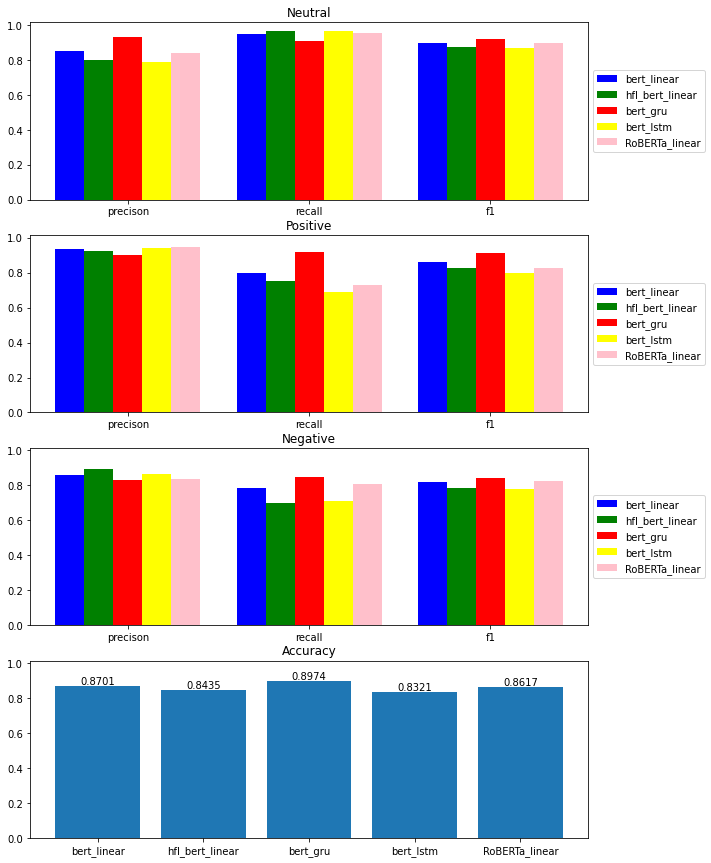

In [23]:
data_0 = data_lst[0]

data_1 = data_lst[1]

data_2 = data_lst[2]


X = np.arange(3)
fig, ax = plt.subplots(4, 1, figsize=(10, 15), sharey=True)
#print(ax)
# df1 = pd.read_csv('bert_linear/test_result.csv')
# df2 = pd.read_csv('hfl_bert_linear/test_result.csv')
# df3 = pd.read_csv('bert_gru/test_result.csv')
# df4 = pd.read_csv('bert_lstm/test_result.csv')
# df5 = pd.read_csv('RoBERTa_linear/test_result.csv')
# df6 = pd.read_csv('test_result.csv')

ax[0].bar(X - 0.32, data_0[0], color = 'b', width = 0.16, label = 'bert_linear')
ax[0].bar(X - 0.16, data_0[1], color = 'g', width = 0.16, label = 'hfl_bert_linear')
ax[0].bar(X - 0, data_0[2], color = 'r', width = 0.16, label = 'bert_gru')
ax[0].bar(X + 0.16, data_0[3], color = 'yellow', width = 0.16, label = 'bert_lstm')
ax[0].bar(X + 0.32, data_0[4], color = 'pink', width = 0.16, label = 'RoBERTa_linear')
ax[0].set_title("Neutral")
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_xticks(np.arange(3), ['precison', 'recall', 'f1'])

ax[1].bar(X - 0.32, data_1[0], color = 'b', width = 0.16, label = 'bert_linear')
ax[1].bar(X - 0.16, data_1[1], color = 'g', width = 0.16, label = 'hfl_bert_linear')
ax[1].bar(X - 0, data_1[2], color = 'r', width = 0.16, label = 'bert_gru')
ax[1].bar(X + 0.16, data_1[3], color = 'yellow', width = 0.16, label = 'bert_lstm')
ax[1].bar(X + 0.32, data_1[4], color = 'pink', width = 0.16, label = 'RoBERTa_linear')
ax[1].set_title("Positive")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_xticks(np.arange(3), ['precison', 'recall', 'f1'])

ax[2].bar(X - 0.32, data_2[0], color = 'b', width = 0.16, label = 'bert_linear')
ax[2].bar(X - 0.16, data_2[1], color = 'g', width = 0.16, label = 'hfl_bert_linear')
ax[2].bar(X - 0, data_2[2], color = 'r', width = 0.16, label = 'bert_gru')
ax[2].bar(X + 0.16, data_2[3], color = 'yellow', width = 0.16, label = 'bert_lstm')
ax[2].bar(X + 0.32, data_2[4], color = 'pink', width = 0.16, label = 'RoBERTa_linear')
ax[2].set_title("Negative")
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].set_xticks(np.arange(3), ['precison', 'recall', 'f1'])

data_3 = [e1['accuracy'],e2['accuracy'],e3['accuracy'], e4['accuracy'], e5['accuracy']]
ax3 = ax[3]
recs = ax3.bar(np.arange(5), data_3)
ax3.set_title("Accuracy")
ax3.set_yticks(np.arange(0,1.1,0.2))
ax3.set_xticks(np.arange(5), ['bert_linear', 'hfl_bert_linear', 'bert_gru','bert_lstm','RoBERTa_linear'])
for rec in recs:
        height = rec.get_height()
        plt.text(rec.get_x()+rec.get_width()/2, height, "%.4f"%(height), ha='center',va='bottom')

plt.show()

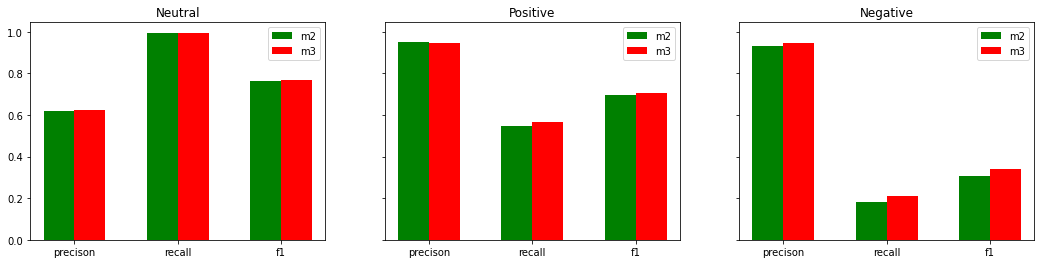

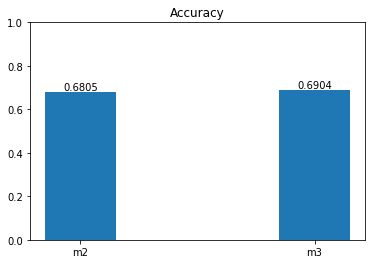

In [ ]:
data_0 = [[et2['中性']['precision'], et2['中性']['recall'], et2['中性']['f1']],
          [et3['中性']['precision'], et3['中性']['recall'], et3['中性']['f1']]]

data_1 = [[et2['正面']['precision'], et2['正面']['recall'], et2['正面']['f1']],
          [et3['正面']['precision'], et3['正面']['recall'], et3['正面']['f1']]]

data_2 = [[et2['负面']['precision'], et2['负面']['recall'], et2['负面']['f1']],
          [et3['负面']['precision'], et3['负面']['recall'], et3['负面']['f1']]]

X = np.arange(3)
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True)


# df1 = pd.read_csv('bert_linear/test_result.csv')
# df2 = pd.read_csv('hfl_bert_linear/test_result.csv')
# df3 = pd.read_csv('bert_gru/test_result.csv')
# df4 = pd.read_csv('bert_lstm/test_result.csv')
# df5 = pd.read_csv('RoBERTa_linear/test_result.csv')
# df6 = pd.read_csv('test_result.csv')

ax[0].bar(X - 0.15, data_0[0], color = 'g', width = 0.3, label = 'm2')
ax[0].bar(X + 0.15, data_0[1], color = 'r', width = 0.3, label = 'm3')
ax[0].set_title("Neutral")

ax[1].bar(X - 0.15, data_1[0], color = 'g', width = 0.3, label = 'm2')
ax[1].bar(X + 0.15, data_1[1], color = 'r', width = 0.3, label = 'm3')
ax[1].set_title("Positive")

ax[2].bar(X - 0.15, data_2[0], color = 'g', width = 0.3, label = 'm2')
ax[2].bar(X + 0.15, data_2[1], color = 'r', width = 0.3, label = 'm3')
ax[2].set_title("Negative")

for a in ax:
        a.set_xticks(np.arange(3), ['precison', 'recall', 'f1'])
        a.legend()

data_3 = [et2['accuracy'],et3['accuracy']]

fig2, ax3 = plt.subplots()
recs = ax3.bar(np.arange(2), data_3, width=0.3)
ax3.set_title("Accuracy")
ax3.set_yticks(np.arange(0,1.1,0.2))
ax3.set_xticks(np.arange(2), ['m2', 'm3'])
for rec in recs:
        height = rec.get_height()
        plt.text(rec.get_x()+rec.get_width()/2, height, "%.4f"%(height), ha='center',va='bottom')
        
plt.show()

In [ ]:
df2[df2.label != df2.id][df2.id == 0][df2.label == 1]

C:\Users\alienware\AppData\Local\Temp\ipykernel_1056\2023674489.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2[df2.label != df2.id][df2.id == 0][df2.label == 1]


,id,label
14,0,1
42,0,1
84,0,1
152,0,1
217,0,1
...,...,...
6311,0,1
6363,0,1
6432,0,1
6463,0,1


In [ ]:
df2.id

0       0
1       0
2       0
3       0
4       0
       ..
6530    0
6531    0
6532    2
6533    0
6534    1
Name: id, Length: 6535, dtype: int64